### Recreating Figure 2C from Bloniasz, Oyama, and Stephen (2024)

In [4]:
import matplotlib.pyplot as plt
import os
import numpy as np
from filtered_point_process.PointProcess import PointProcessModel
from filtered_point_process.FPP import FilteredPointProcess
from filtered_point_process.visualization import Visualizer

#!pip install numdifftools

import numdifftools as nd


import nitime.algorithms as tsa
import nitime.utils as tsu
from scipy.signal import find_peaks
import matplotlib.ticker as mticker
from matplotlib.ticker import FuncFormatter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numdifftools as nd


# 5000: 25000

In [5]:
# Setting Parameters

params = {
    "method": "gaussian",
    "peak_height": 5000,
    "center_frequency": 1,
    "peak_width": 0.1,
    "fs": 1000.0,
    "T": 60,
    "Nsims": 1,
    "lambda_0": [500],
}

model_1 = PointProcessModel(params=params, seed=20)
model_1.simulate_pp()  # Simulate the CIF model for model_1

# Define the filters to be used
filters = {"filter_1": "GABA", "filter_2": "1/f"}

# Instantiate the FilteredPointProcess class with the specified filters and model
fpp = FilteredPointProcess(filters=filters, model=model_1)

In [6]:
model_1.pp_time_axis

array([0.0000e+00, 1.0000e-03, 2.0000e-03, ..., 5.9997e+01, 5.9998e+01,
       5.9999e+01])

In [7]:
# Custom Plotting Parameters for Paper (non-stylized plotting functions are available directly in the package)

cif_copy = np.real(np.abs(fpp.model.cif_realization[1000:3500]))

## Function for "create_spike_train" is a private function in FPP, but is retrieved below for plotting purposes

create_spike_train_method = getattr(fpp, "_create_spike_train")

spikes_GABA = create_spike_train_method(
    spike_times=fpp.model.pp_events, time_axis=fpp.model.pp_time_axis, fs=params["fs"]
)[1000:3500]

In [8]:
## Perform Convolutions to retreive the simulated LFPs.

convolution_results = fpp.perform_convolutions()

# Retrieve spectra
spectra = fpp.get_spectra()

Notice below that we can see the names of the filters clearly auto-generated to ensure clarity when interacting with various combinations of parameters.

In [9]:
print(convolution_results.keys())
print(spectra.keys())

dict_keys(['pp ⨂ GABA', 'pp ⨂ GABA ⨂ 1/f'])
dict_keys(['pp * GABA', 'pp * GABA * 1/f'])


Here, we are using "PSPs" to mean post-synaptic potentials. Note that we also shortten the time axis to -1 to focus on 2.5 seconds of the simulation after the "burn-in" period which is intrinsic to a filtered point process model. 

In [10]:
sim_PSPs_GABA = convolution_results[list(convolution_results.keys())[0]][1000:3500]
sim_PSPs_GABA_1f = convolution_results[list(convolution_results.keys())[1]][1000:3500]
t = fpp.model.cif_time_axis[1000:3500]

frequencies = fpp.model.cif_frequencies
cif_PSD = fpp.model.cif_PSD
pp_PSD = fpp.model.pp_PSD


# Spectrum after 1st filter
h_spectrum = spectra.get("pp * GABA")

# Spectrum after 2nd filter
final_spectrum = spectra.get("pp * GABA * 1/f")

In [12]:
sim_PSPs_GABA_spectrum = convolution_results[list(convolution_results.keys())[0]]
sim_PSPs_GABA_1f_spectrum = convolution_results[list(convolution_results.keys())[1]]

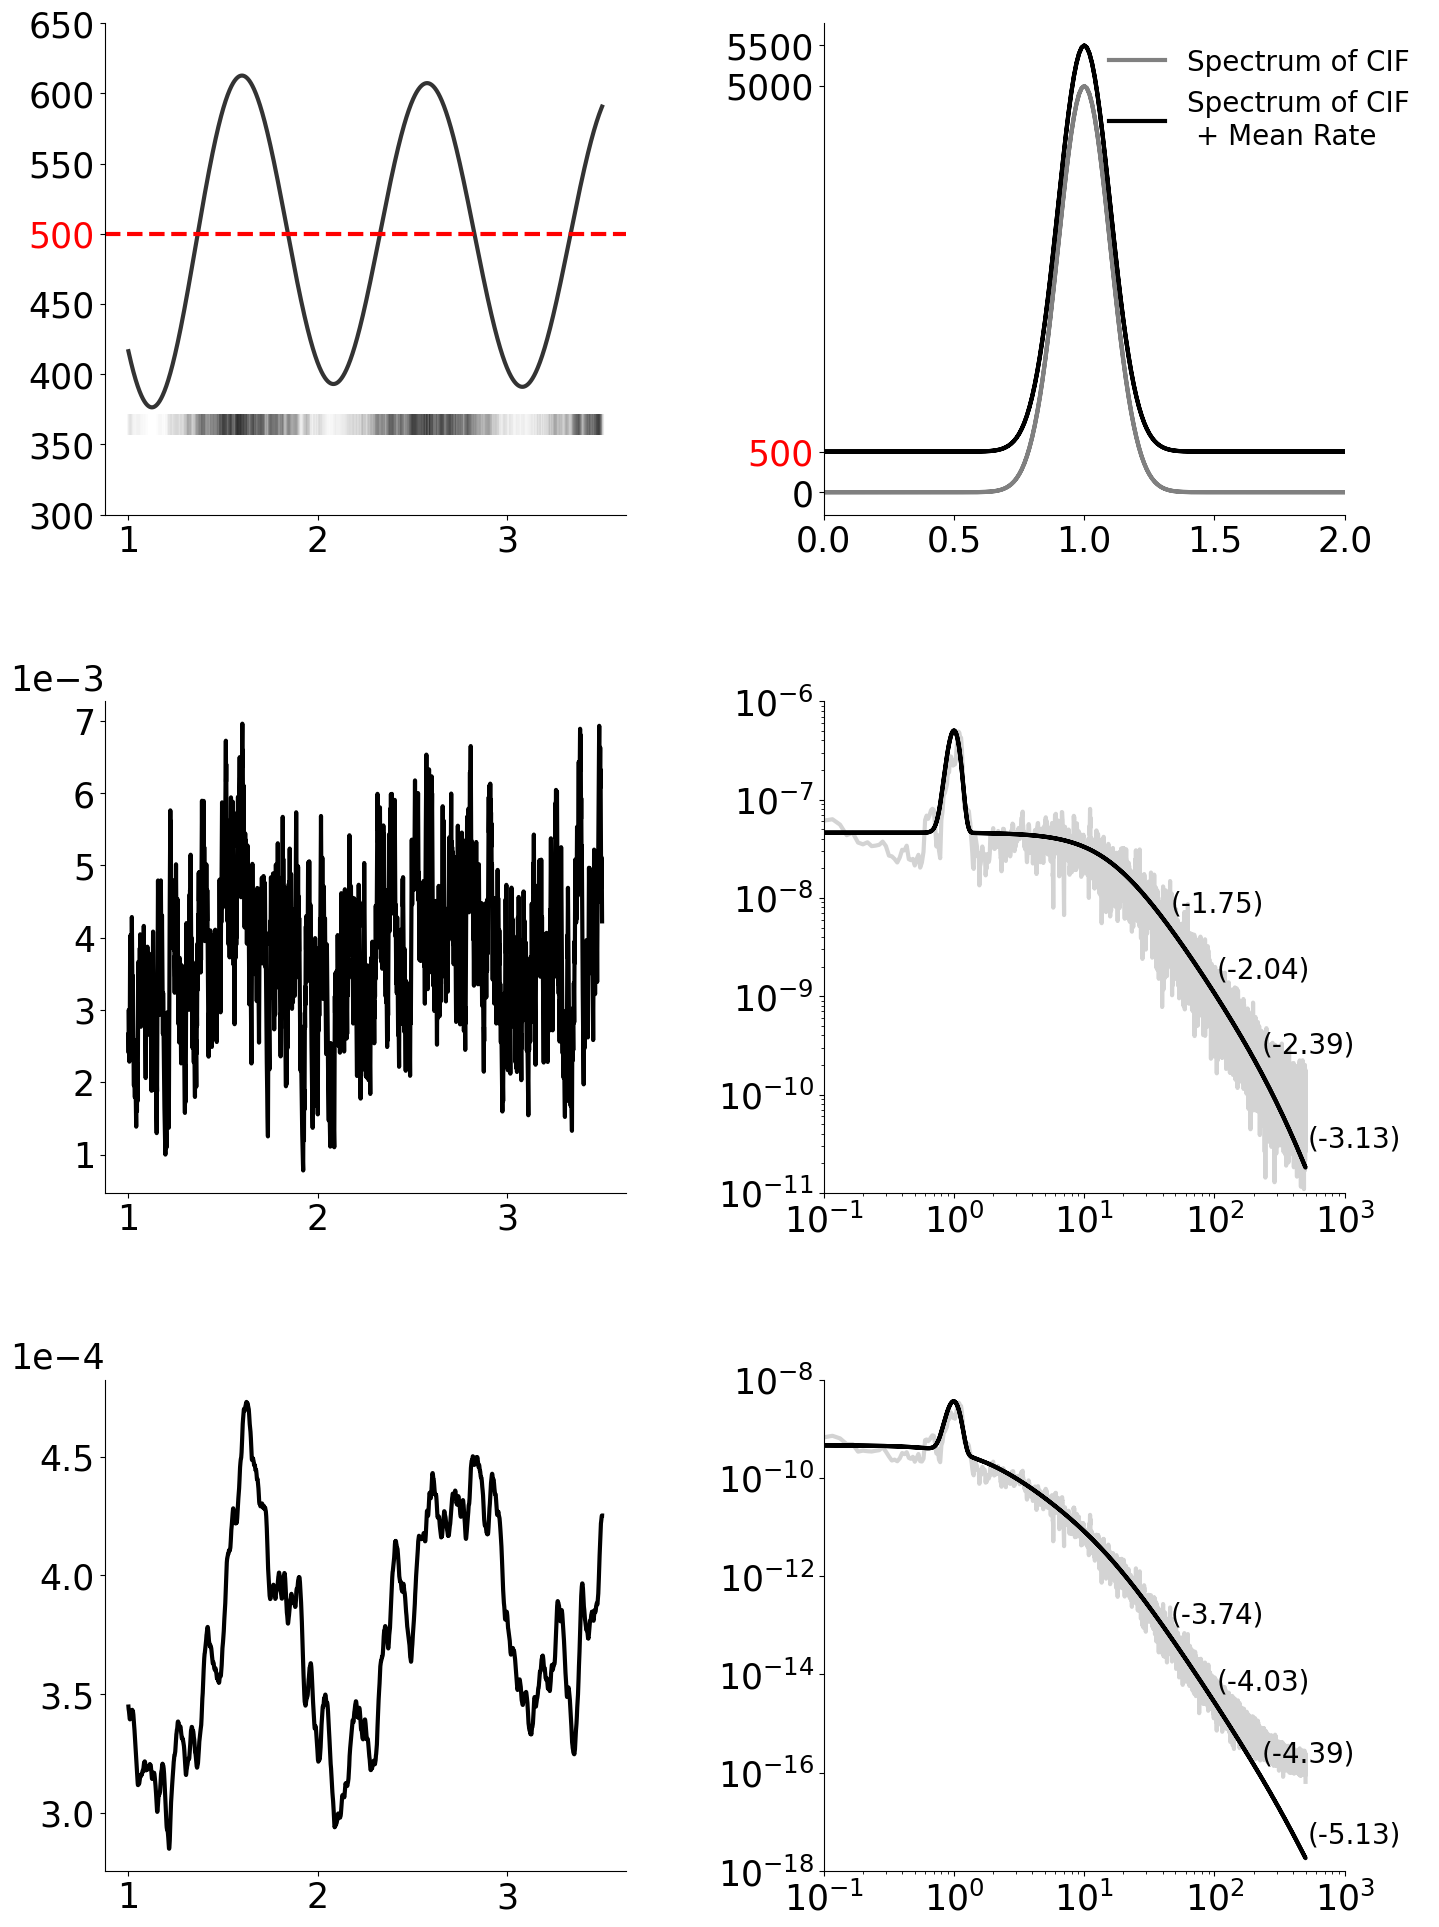

In [13]:
plt.rc("xtick", labelsize=25)  # Set x-tick label size
plt.rc("ytick", labelsize=25)  # Set y-tick label size
plt.rc("axes", labelsize=14)  # Set x and y labels size
plt.rcParams["lines.linewidth"] = 3


## Slope calculation using nd.Derivative
def log_log_slope(f, spectrum, frequencies):
    idx = np.argmin(np.abs(frequencies - f))  # Find the closest index
    d_log_spectrum = nd.Derivative(
        lambda log_f: np.log10(spectrum[np.argmin(np.abs(frequencies - 10**log_f))])
    )
    return d_log_spectrum(np.log10(frequencies[idx]))


# Perform multitaper spectral estimation
freqs_GABA, psd_GABA, nu = tsa.multi_taper_psd(
    sim_PSPs_GABA_spectrum, Fs=params["fs"], NW=4, adaptive=False
)
freqs_GABA_1f, psd_GABA_1f, nu = tsa.multi_taper_psd(
    sim_PSPs_GABA_1f_spectrum, Fs=params["fs"], NW=4, adaptive=False
)

# Set up the figure and subplots
fig, axs = plt.subplots(3, 2, figsize=(16, 24))

# Plot the CIF on the primary y-axis
axs[0, 0].plot(t, cif_copy, color="black", alpha=0.8)  # Plot the real part of CIF

# Normalize CIF values
cif_min, cif_max = np.min(cif_copy), np.max(cif_copy)
normalized_cif = (cif_copy - cif_min) / (cif_max - cif_min)

# Map normalized CIF values to desired alpha range
alpha_range_min, alpha_range_max = 0.001, 0.1
scaled_alpha = alpha_range_min + (alpha_range_max - alpha_range_min) * normalized_cif

# Add spike plots with dynamic alpha
spike_indices = np.nonzero(spikes_GABA)[0]
for spike_index in spike_indices:
    spike_time = t[spike_index]
    alpha = scaled_alpha[spike_index]
    axs[0, 0].vlines(
        spike_time, ymin=cif_min - 20, ymax=cif_min - 5, color="black", alpha=alpha
    )

# Add a horizontal red dashed line at y=500 and customize the 500 tick label
axs[0, 0].axhline(y=500, color="red", linestyle="--")

yticks = axs[0, 0].get_yticks()
if 500 not in yticks:
    yticks = np.append(yticks, 500)
axs[0, 0].set_yticks(yticks)

# Set tick labels and color the 500 label red
axs[0, 0].set_yticklabels([f"{int(y)}" for y in yticks])
for label in axs[0, 0].get_yticklabels():
    if label.get_text() == "500":
        label.set_color("red")

# Set the limits for the raster plot y-axis
axs[0, 0].tick_params(axis="y", labelcolor="black")
axs[0, 0].spines["top"].set_visible(False)
axs[0, 0].spines["right"].set_visible(False)
axs[0, 0].set_ylim([cif_min - 30, cif_max + 30])

# Plot 1b: Power spectra
axs[0, 1].plot(frequencies, cif_PSD, label="Spectrum of CIF", color="grey")
axs[0, 1].plot(
    frequencies, pp_PSD, label="Spectrum of CIF \n + Mean Rate", color="black"
)
axs[0, 1].set_xlim(0, 2)

# Set custom y-axis ticks and make 500 red
axs[0, 1].set_yticks([0, 500, 5000, 5500])
axs[0, 1].get_yticklabels()[axs[0, 1].get_yticks().tolist().index(500)].set_color("red")

# Adding legends
legend_main = axs[0, 1].legend(
    loc="upper left", bbox_to_anchor=(0.5, 1), frameon=False, fontsize=20
)


## Slope calculations

# Plot 2a: sim_PSPs_GABA
axs[1, 0].plot(t, sim_PSPs_GABA, color="black")


axs[1, 1].loglog(freqs_GABA, psd_GABA, color="lightgrey", label="GABA Multitaper PSD")
axs[1, 1].loglog(
    frequencies, h_spectrum, label="GABA Filter Power Spectrum", color="black"
)
axs[1, 1].set_xlim([0.1, 1000])
axs[1, 1].set_ylim([1e-11, 1e-6])


# Plot 3a: sim_PSPs_GABA_1f
axs[2, 0].plot(t, sim_PSPs_GABA_1f, color="black")


axs[2, 1].loglog(
    freqs_GABA_1f, psd_GABA_1f, color="lightgrey", label="GABA 1/f Multitaper PSD"
)
axs[2, 1].loglog(
    frequencies, final_spectrum, label="1/f-like filtered Power Spectrum", color="black"
)
axs[2, 1].set_xlim([0.1, 1000])
axs[2, 1].set_ylim([1e-18, 1e-8])


def annotate_slope(
    ax,
    spectrum,
    frequencies,
    selected_frequencies=None,
    label_color="black",
    label_size=20,
    label_shift=(1.15, 1.15),
):
    """
    Annotates slopes at selected frequencies on a log-log scale for a given spectrum.
    """
    if selected_frequencies is None:
        selected_frequencies = np.logspace(np.log10(40), np.log10(450), 4)

    def log_log_slope(f, spectrum, frequencies):
        idx = np.argmin(np.abs(frequencies - f))  # Find the closest index
        d_log_spectrum = nd.Derivative(
            lambda log_f: np.log10(spectrum[np.argmin(np.abs(frequencies - 10**log_f))])
        )
        return d_log_spectrum(np.log10(frequencies[idx]))

    for f in selected_frequencies:
        idx = np.argmin(
            np.abs(frequencies - f)
        )  # Get closest index for the selected frequency
        slope = log_log_slope(
            frequencies[idx], spectrum, frequencies
        )  # Calculate slope
        # Log-log shift (adjust on the log scale to avoid overlap)
        ax.text(
            frequencies[idx] * label_shift[0],  # Multiplicative shift in log scale
            spectrum[idx] * label_shift[1],  # Shift y in log scale
            f"({slope:.2f})",
            fontsize=label_size,
            color=label_color,
        )


annotate_slope(axs[1, 1], h_spectrum, frequencies)
annotate_slope(axs[2, 1], final_spectrum, frequencies)

for i in range(3):
    for j in range(2):
        # Remove the box by hiding the top and right spines
        axs[i, j].spines["top"].set_visible(False)
        axs[i, j].spines["right"].set_visible(False)

for i in range(axs.shape[0]):
    for j in range(axs.shape[1]):
        ax = axs[i, j]
        # Skip the first row's first and second columns
        if i == 0 and j in [0, 1]:
            continue

        # Check if the axis is log-scaled to avoid applying inappropriate formatting
        if not isinstance(
            ax.yaxis.get_major_formatter(), mticker.LogFormatterSciNotation
        ):
            ax.ticklabel_format(style="sci", axis="y", scilimits=(0, 0))
            # Move the exponent (offset text) to the top of the y-axis
            ax.yaxis.offsetText.set_position((0, 1))
            ax.yaxis.offsetText.set_verticalalignment("bottom")
            ax.yaxis.offsetText.set_horizontalalignment("right")
            ax.spines["right"].set_visible(False)
            ax.spines["top"].set_visible(False)


yticks = axs[0, 0].get_yticks()
if 500 not in yticks:
    yticks = np.append(yticks, 500)
axs[0, 0].set_yticks(yticks)

axs[0, 0].set_yticklabels([f"{int(y)}" for y in yticks])
for label in axs[0, 0].get_yticklabels():
    if label.get_text() == "500":
        label.set_color("red")
# Adjust the layout
fig.subplots_adjust(hspace=0.38, wspace=0.38)

plt.rc("xtick", labelsize=25)  # Set x-tick label size
plt.rc("ytick", labelsize=25)  # Set y-tick label size
plt.rc("axes", labelsize=14)  # Set x and y labels size
plt.rcParams["lines.linewidth"] = 3


plt.show()